# Intuitive Physics in Gen

This notebook shows how to build probabilistic models of intuitive physics. It focuses on inferring physical object properties (mass, bounciness) from sequentially observed video input.

<div class="alert alert-info" markdown="1">
    <strong> Note on installing necessary packages </strong>

Before you run the code on this notebook, you need to first install `pybullet` (https://pypi.org/project/pybullet/) in your phython environment. Make sure that the same python environment is specfiied in Julia.
    
```julia
ENV["PYTHON"] = [PATH TO YOUR PYTHON IN WHICH PYBULLET WAS INSTALLED]
Pkg.build("PYCall")

```
    
</div>



In [1]:
using Gen;
using Pkg;

We will use [pybullet](https://pybullet.org/wordpress/), a real time physics engine, under the hood to create physics-based temporal generative models.The `PyCall` package should take care of this for you in `pyimport`. 

In [2]:
using PyCall
pb = pyimport("pybullet")

pybullet build time: Mar  9 2024 22:48:14


PyObject <module 'pybullet' from '/Users/tianminshu/anaconda3/envs/CogAI/lib/python3.7/site-packages/pybullet.cpython-37m-darwin.so'>

Next, we will load Julia helper code that provides functionality for inference over physical scenes. 

In [3]:
include("PhySimHelperCode.jl")
# the following package allows us to more nicely/easily update contents of 
# structs that contain object state information
Pkg.add("Accessors");
Pkg.add("Distributions");
using Accessors; 
using Distributions;

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


## Part 1: Generative Physics Model

The generative model (`model`) consists of a hypothesis over objects in the scene and uses the `bullet` physics engine to produce a sequence of predictions about the object state across time.

This part will codify the following diagram in a generative model -- we will remain at an abstract level not yet thinking about exactly what we are simulating. We will make things concrete in Part 2.

![Physics Graphical Model](media/phys_gm.png)

The generative model is split up into several small generative functions: 

1) `prior` samples new latents (mass and restitution) defining the initial world state
2) `kernel` simulates `T` steps into the future, generating world states for each step
3) `observe` generates noisy observations over object positions (in $\mathcal{R}^3$) for a given state

In [4]:
# a helper function to update the state contained in a struct called RigidBodyLatents
# Notice that RigidBodyLatents contains all of the latent variables that we wish to make inferences about
function update_latents(ls::RigidBodyLatents, mass::Float64, res::Float64)
    RigidBodyLatents(setproperties(ls.data;
                           mass=mass,
                           restitution=res))
end

update_latents (generic function with 1 method)

The prior is defined over the mass and restitution of an object (that will fall from a height and bounce). Notice that these latents are stored in the `RigidBodyLatents` struct.

In [5]:
@gen function prior(ls::RigidBodyLatents)
    mass = {:mass} ~ gamma(1.2, 10.)
    res = {:restitution} ~ uniform(0, 1)
    new_latents = update_latents(ls, mass, res)
    return new_latents
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[RigidBodyLatents], false, Union{Nothing, Some{Any}}[nothing], var"##prior#225", Bool[0], false)

The function `observe` defines our likelihood function. Given the current physical state, it emits noisy positions in space (xyz) as the observation space.

Notice that this model *assumes* a non-visual observation space &ndash; the kinematic state (in this case, just the 3D position) of an object is something perception would need to additionally infer to make physical inferences. 

<div class="alert alert-warning" markdown="1">
    
**Exercise:** Think about how you would extend this model to work on raw visual inputs (e.g., pixels). 
</div>

In [6]:
@gen function observe(k::RigidBodyState)
    pos = k.position # XYZ position
    # add noise to position of each object (via the Map combinator)
    # however, notice that the example we will work out will include only 1 object
    obs = {:kinematics} ~ broadcasted_normal(pos, 0.1)
    return obs
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[RigidBodyState], false, Union{Nothing, Some{Any}}[nothing], var"##observe#226", Bool[0], false)

Now let's move to the kernel of the generative model as well as the use of th Unfold combinator to realize a temporal generative model. Notice that the kernel makes a call to the physics engine to step the simulation one time step forward, using `PhySMC.step(...)`. This implements temporal dynamics in the generative model, the horizontal arrow from the figure above. 

(The helper code `PhySMC` provides an appropriate abstraction for interfacing probabilistic programming and physics engine states.)  

The return value of this call, `next_state` is a kinematic state (position, velocity, orientation) of a rigid body (i.e., the object we are simulating).

In [7]:
@gen function kernel(t::Int, prev_state::BulletState, sim::BulletSim)
    # use of PhySMC.step to step the simulation forward one time step
    next_state::BulletState = step(sim, prev_state)
    # `next_state.kinematics = [RigidBodyState]` G
    obs = {:observe} ~ Gen.Map(observe)(next_state.kinematics)
    return next_state
end

@gen function model(T::Int, sim::BulletSim, template::BulletState)
    # distribution over mass and restitution for objects from the prior
    latents = {:prior} ~ Gen.Map(prior)(template.latents)
    init_state = Accessors.setproperties(template; latents=latents)
    # simulate `T` timesteps
    states = {:kernel} ~ Gen.Unfold(kernel)(T, init_state, sim)
    return states
end;

## Part 2: Defining a physical scene

To make the `model` concrete in a physical scenario, all we need to do is to initialize a scene configuration, which can then be simulated forward.

Here, we initialize a simple scene: a table and a ball above its center. 

In [8]:
function simple_scene(mass::Float64=1.0, restitution::Float64=0.9)
    # `pb` is the `pybullet` python package
    # initialize a physics server in pybullet
    
    # use the following line to create a simulation without a GUI interface for visualization
    # recommended for running the code in the jupyter notebook
    # because we are not rendering images, the simulation also runs faster
    client = @pycall pb.connect(pb.DIRECT)::Int64
    
    # use the following line to create a GUI interface to visual simulation
    # not recommended for running the code in the jupyter notebook
#     client = @pycall pb.connect(pb.GUI)::Int64
    
    
    # gotta set the gravity
    pb.setGravity(0,0,-10; physicsClientId=client)

    # add a table
    dims = [1.0, 1.0, 0.1] # in meters
    col_id = pb.createCollisionShape(pb.GEOM_BOX,
                                     halfExtents=dims,
                                     physicsClientId=client)
    obj_id = pb.createMultiBody(baseCollisionShapeIndex=col_id,
                                basePosition=[0., 0., -0.1],
                                physicsClientId=client)
    pb.changeDynamics(obj_id,
                      -1;
                      mass=0., # 0 mass means this object does not move (it's stationary)
                      restitution=0.9, # some is necessary; we could learn or infer this parameter
                      physicsClientId=client)


    # add a ball
    bcol_id = pb.createCollisionShape(pb.GEOM_SPHERE,
                                      radius=0.1,
                                      physicsClientId=client)
    bobj_id = pb.createMultiBody(baseCollisionShapeIndex=bcol_id,
                                 basePosition=[0., 0., 1.0],
                                 physicsClientId=client)
    pb.changeDynamics(bobj_id,
                      -1;
                      mass=mass,
                      restitution=restitution,
                      physicsClientId=client)

    (client, bobj_id)
end

# start with a ball above a table
client, ball_id = simple_scene()
# configure simulator with the provided
# client id
sim = BulletSim(; client=client)
# This is the object of interest in the scene
# (the table is static)
ball = RigidBody(ball_id)
# Retrieve the default latents for the ball
# as well as its initial positions
# Note: alternative latents will be suggested by the `prior`
init_state = BulletState(sim, [ball])
# arguments for `model`
gargs = (60, # number of steps (total duration 1s)
         sim,
         init_state);

With the simulator configured to start with the template scene, we can go ahead and run the generative model.

<div class="alert alert-info" markdown="1">
    
Note how the different physical and kinematic properties of the objects are referenced in a generic way in `model`. This allows us to start with more complex scenes than the one we use in this example. 
</div>

In [9]:
# execute `model`
trace, _ = generate(model, gargs);
get_choices(trace)

│
├── :prior
│   │
│   └── 1
│       │
│       ├── :restitution : 0.36689928407573646
│       │
│       └── :mass : 1.8292166533213319
│
└── :kernel
    │
    ├── 1
    │   │
    │   └── :observe
    │       │
    │       └── 1
    │           │
    │           └── :kinematics : [0.009368471815634365, -0.06138665791071072, 1.1850561410021254]
    │
    ├── 2
    │   │
    │   └── :observe
    │       │
    │       └── 1
    │           │
    │           └── :kinematics : [0.11355727355901808, 0.13485683922634992, 1.0862772398379494]
    │
    ├── 3
    │   │
    │   └── :observe
    │       │
    │       └── 1
    │           │
    │           └── :kinematics : [0.14487544397562538, 0.0077629686939310605, 1.1074578185264883]
    │
    ├── 4
    │   │
    │   └── :observe
    │       │
    │       └── 1
    │           │
    │           └── :kinematics : [-0.02167544851820825, 0.10189786167291473, 0.8552056094083045]
    │
    ├── 5
    │   │
    │   └── :observe
    │       │
    │    

 Let's also create a helper function to visualize the height of the ball as a function of time

> `pybullet` comes with a debug gui to visualize simulations but this would require a complicated setup for jupyter notebooks.

In [10]:
using Plots;

@userplot SimPlot
@recipe function f(cp::SimPlot)
    z, t = cp.args
    cs = size(z, 1)
    k = 10
    inds = (max(1, t-k):t)
    n = length(inds)
    linewidth --> range(0, 10, length = n)
    seriesalpha --> range(0, 1, length = n)
    xguide --> "time"
    yguide --> "height of ball (z)"
    ylims --> (0, 1.0)
    xlims --> (1, 60)
    label --> false
    inds, z[inds, :]
end

function get_zs(trace::Gen.Trace)
    t, _... = get_args(trace)
    states = get_retval(trace)
    zs = Vector{Float64}(undef, t)
    for i = 1:t
        zs[i] = states[i].kinematics[1].position[3]
    end
    return zs
end

function animate_trace(trace::Gen.Trace; label = "trace")
    t = first(get_args(trace))
    zs = reshape(get_zs(trace), (t, 1))
    anim = @animate for i = 2:t
        simplot(zs, i, label = label)
    end
end;

[ Info: Saved animation to /Users/tianminshu/Documents/Courses/CognitiveAI/Slides/Week 8/Intuitive Physics in Gen/tmp.gif


Plots.AnimatedGif("/Users/tianminshu/Documents/Courses/CognitiveAI/Slides/Week 8/Intuitive Physics in Gen/tmp.gif")
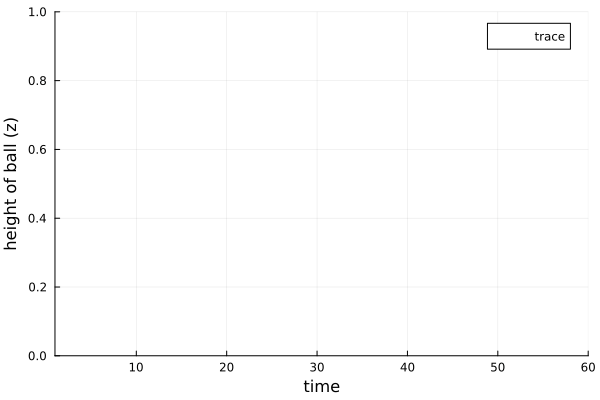

In [11]:
anim = animate_trace(trace)
gif(anim, fps = 24)

By repeatedly running `Gen.generate` on `model`, we draw a variety of samples from the prior and thus traces. Here, we visualize how traces that sample a range of physical properties for the ball lead to different timecourses. 

In [12]:
traces = [first(generate(model, gargs)) for _=1:5];

In [13]:
function animate_traces(traces::Vector{<:Gen.Trace})
    n = length(traces)
    zzs = reduce(hcat, map(get_zs, traces))
    t = size(zzs, 1)
    anim = @animate for i=2:t
        simplot(zzs, i)
    end
end

animate_traces (generic function with 1 method)

[ Info: Saved animation to /Users/tianminshu/Documents/Courses/CognitiveAI/Slides/Week 8/Intuitive Physics in Gen/tmp.gif


Plots.AnimatedGif("/Users/tianminshu/Documents/Courses/CognitiveAI/Slides/Week 8/Intuitive Physics in Gen/tmp.gif")
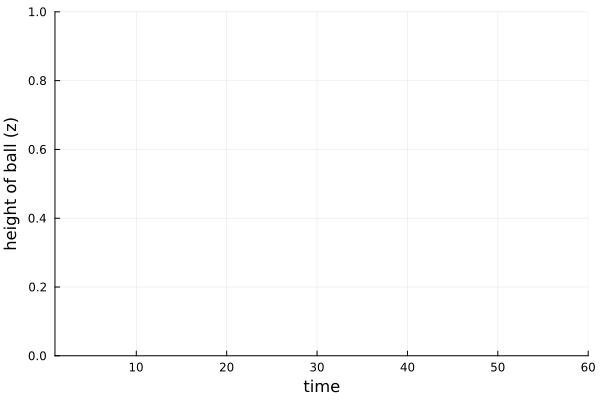

In [14]:
gif(animate_traces(traces), fps=24)

The following traces are sampled with the fixed restitution:

[ Info: Saved animation to /Users/tianminshu/Documents/Courses/CognitiveAI/Slides/Week 8/Intuitive Physics in Gen/tmp.gif


Plots.AnimatedGif("/Users/tianminshu/Documents/Courses/CognitiveAI/Slides/Week 8/Intuitive Physics in Gen/tmp.gif")
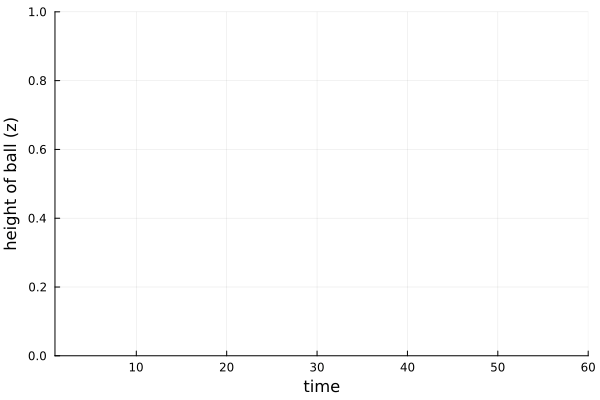

In [15]:
traces = [first(generate(model, gargs, choicemap(
    (:prior => 1 => :restitution, 0.8), 
))) for _=1:5];

gif(animate_traces(traces), fps=24)

The following traces are sampled with the fixed mass:

[ Info: Saved animation to /Users/tianminshu/Documents/Courses/CognitiveAI/Slides/Week 8/Intuitive Physics in Gen/tmp.gif


Plots.AnimatedGif("/Users/tianminshu/Documents/Courses/CognitiveAI/Slides/Week 8/Intuitive Physics in Gen/tmp.gif")
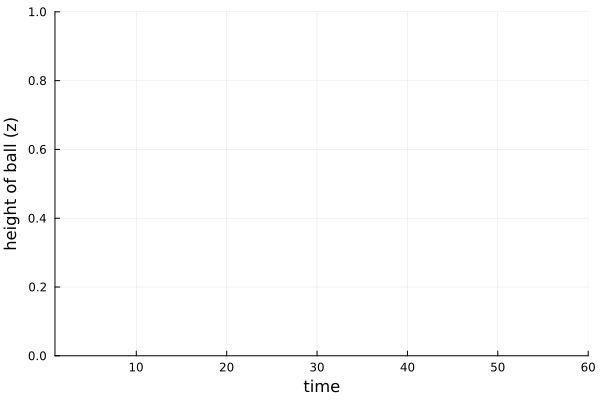

In [16]:
traces = [first(generate(model, gargs, choicemap(
    (:prior => 1 => :mass, 1.0), 
))) for _=1:5];

gif(animate_traces(traces), fps=24)

Note how restitution, and not mass, has any effect on the resulting trajectory.

## Part 3: Inference over dynamic scenes

Now that we have implemented a generative model over this simple scene, we can perform inferences in it given a set of observed positions

Let's start with generating a synthetic observation.

[ Info: Saved animation to /Users/tianminshu/Documents/Courses/CognitiveAI/Slides/Week 8/Intuitive Physics in Gen/tmp.gif


Plots.AnimatedGif("/Users/tianminshu/Documents/Courses/CognitiveAI/Slides/Week 8/Intuitive Physics in Gen/tmp.gif")
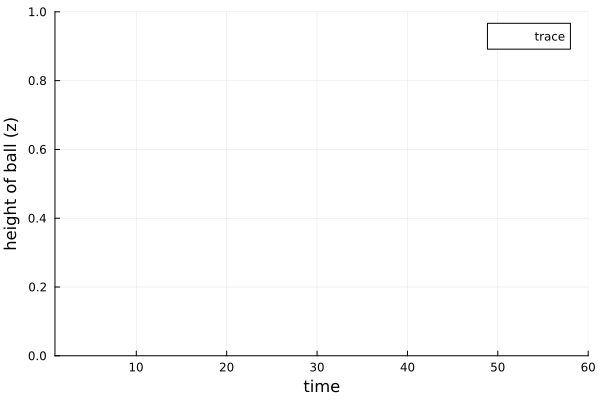

In [17]:
# First, let's generate a scene with a specific mass and restitution 
# Our goal is to generate a simulated observation that we can work with
gt_latents = choicemap(
    (:prior => 1 => :restitution, 0.8), 
    (:prior => 1 => :mass, 1.0)
)
gt = first(generate(model, gargs, gt_latents));
gt_choices = get_choices(gt)

t = gargs[1]

# one set of observations per time step
# (notice that these do not contain gt latents)
observations = Vector{Gen.ChoiceMap}(undef, t)
for i = 1:t
    cm = choicemap()
    addr = :kernel => i => :observe
    set_submap!(cm, addr, get_submap(gt_choices, addr))
    observations[i] = cm
end

gif(animate_trace(gt), fps=24)

Here, we define the inference procedure: a particle filter 

In [18]:
include("truncatednorm.jl");

# this proposal function implements a truncated Gaussian drift for mass and restitution
@gen function proposal(tr::Gen.Trace)
    # get previous values from `tr`
    choices = get_choices(tr)
    prev_mass = choices[:prior => 1 => :mass]
    prev_res  = choices[:prior => 1 => :restitution]
    
    # sample new values conditioned on the old ones
    # (Note: values are truncated to avoid issues with simulation)
    mass = {:prior => 1 => :mass} ~ trunc_norm(prev_mass, .1, 0., Inf)
    restitution = {:prior => 1 => :restitution} ~ trunc_norm(prev_res, .1, 0., 1.)
    
    # the return of this function is not
    # neccessary but could be useful
    # for debugging.
    return (mass, restitution)
end

"""
    inference_procedure

Performs particle filter inference with rejuvenation.
"""
function inference_procedure(gm_args::Tuple,
                             obs::Vector{Gen.ChoiceMap},
                             num_particles::Int=20, num_samples::Int=100)
    get_args(t) = (t, gm_args[2:3]...)

    # initialize particle filter
    state = Gen.initialize_particle_filter(model, get_args(0), EmptyChoiceMap(), num_particles)
    argdiffs = (UnknownChange(), NoChange(), NoChange()) # only the first argument will change
    
    # Then increment through each observation step
    for (t, o) = enumerate(obs)
        # apply a rejuvenation move to each particle
        for i=1:num_particles
            state.traces[i], _ = mh(state.traces[i], proposal, ())
        end

        Gen.maybe_resample!(state, ess_threshold=num_particles/2) 
        Gen.particle_filter_step!(state, get_args(t), argdiffs, o)
    end

    # return the "unweighted" set of traces after t steps
    return Gen.sample_unweighted_traces(state, num_samples)
end;

We can now apply this inference procedure to infer the latents in our model that will best explain the set of observed positions. 

In [19]:
result = inference_procedure(gargs, observations, 20, 20); #should take a few seconds

Visualizing the predictions of these traces, we can see that the inference procedure can generally re-create the ground truth trajectory. 

[ Info: Saved animation to /Users/tianminshu/Documents/Courses/CognitiveAI/Slides/Week 8/Intuitive Physics in Gen/tmp.gif


Plots.AnimatedGif("/Users/tianminshu/Documents/Courses/CognitiveAI/Slides/Week 8/Intuitive Physics in Gen/tmp.gif")
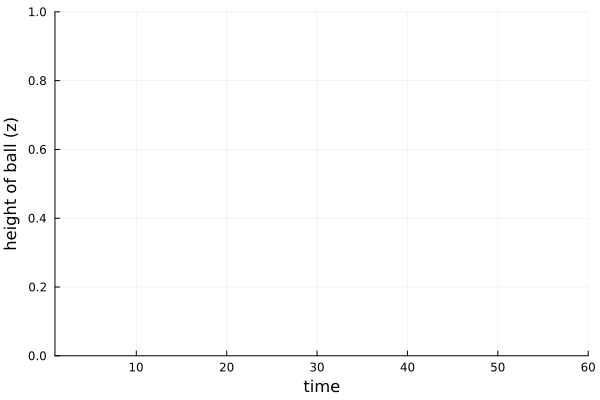

In [20]:
gif(animate_traces(result), fps=24)

By plotting the distribution of inferred latents, we see that indeed restitution converges to the ground truth, while mass varies arbitrarily.

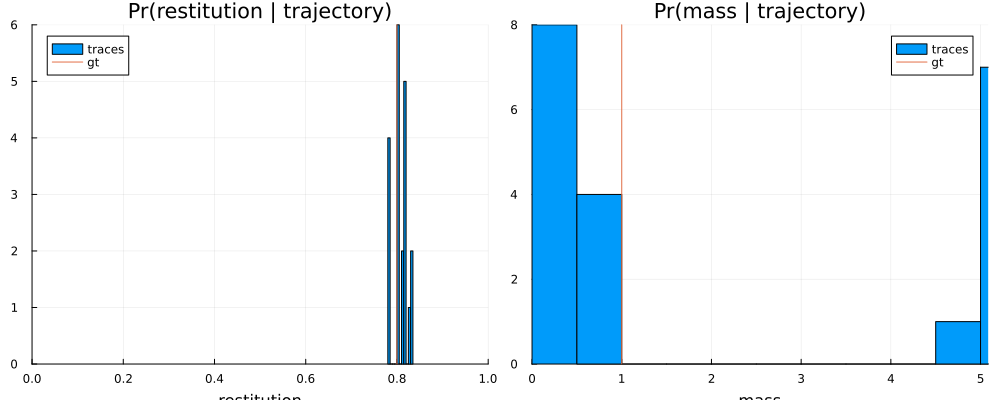

In [21]:
function get_latents(traces::Vector{<:Gen.Trace})
    n = length(traces)
    mass = Vector{Float64}(undef, n)
    restitution = Vector{Float64}(undef, n)
    for i = 1:n
        mass[i] = traces[i][:prior => 1 => :mass]
        restitution[i] = traces[i][:prior => 1 => :restitution]
    end
    (mass, restitution)
end

function plot_latents(traces::Vector{<:Gen.Trace})
    mass, restitution = get_latents(traces)
    res_plt = histogram(
        restitution, title="Pr(restitution | trajectory)", 
        xlabel="restitution", bins=10, label="traces", xlims=(0, 1)
    )
    vline!(res_plt, [0.8], label = "gt") 
    mass_plt = histogram(
        mass, title="Pr(mass | trajectory)",
        xlabel="mass", bins=10, label="traces", xlims=(0, maximum(mass))
    )
    vline!(mass_plt, [1.0], label = "gt") 
    return plot(res_plt, mass_plt,size=(1000,400))
end

plot_latents(result)